In [1]:
# 기본 셋업 
import os, sys, warnings
warnings.filterwarnings("ignore")

# 기본 경로 고정
PROJECT_DIR = r"C:\Users\user\Desktop\daeyeon_project"
DATA_PATH   = os.path.join(PROJECT_DIR, "original_data.xlsx")
os.chdir(PROJECT_DIR)

# 표시 옵션
import pandas as pd
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

# 그래프 셋업
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Malgun Gothic"  # 윈도우 기본 한글 폰트
plt.rcParams["axes.unicode_minus"] = False     # 음수 기호 깨짐 방지

print(f"WORKING DIR: {os.getcwd()}")
print(f"DATA PATH  : {DATA_PATH}")

WORKING DIR: C:\Users\user\Desktop\daeyeon_project
DATA PATH  : C:\Users\user\Desktop\daeyeon_project\original_data.xlsx


In [2]:
import numpy as np
from datetime import datetime

# (필요시 조정할 파라미터)
REFERENCE_DATE = pd.Timestamp(2025, 6, 20)  # 기준일
EPS = 1e-9                                   # 0 나눗셈 방지

# 데이터 로드
df = pd.read_excel("original_data.xlsx", sheet_name="raw")

# 타입/이상치 방어적 처리
df["ship_date"] = pd.to_datetime(df["ship_date"], errors="coerce")
for col in ["qty", "sale_qty"]:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)
    df.loc[df[col] < 0, col] = 0
    
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1975 entries, 0 to 1974
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   biz           1975 non-null   object        
 1   product_code  1975 non-null   object        
 2   gender        1975 non-null   object        
 3   silhouette    1975 non-null   object        
 4   qty           1975 non-null   int64         
 5   sale_qty      1975 non-null   int64         
 6   ship_date     1975 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 108.1+ KB


,qty,sale_qty,ship_date
count,1975.000000,1975.000000,1975
mean,389.816203,62.228354,2024-11-27 03:26:20.354430464
min,2.000000,0.000000,2022-04-25 00:00:00
25%,11.000000,0.000000,2024-09-11 12:00:00
50%,45.000000,2.000000,2025-01-13 00:00:00
75%,194.500000,21.500000,2025-04-15 00:00:00
max,37446.000000,5449.000000,2025-06-20 00:00:00
std,1338.556136,235.312117,NaN


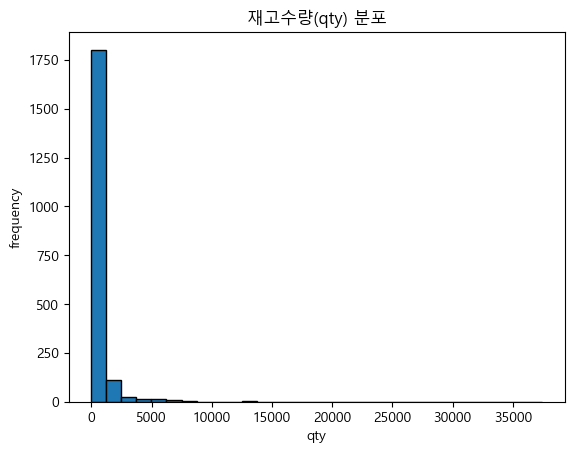

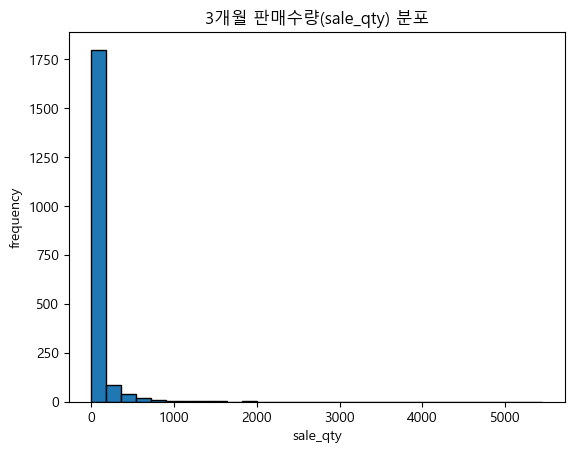

In [3]:
import matplotlib.pyplot as plt

# 분포(히스토그램): qty
plt.figure()
df["qty"].plot(kind="hist", bins=30, edgecolor="black")
plt.title("재고수량(qty) 분포")
plt.xlabel("qty")
plt.ylabel("frequency")
plt.show()

# 분포(히스토그램): sale_qty
plt.figure()
df["sale_qty"].plot(kind="hist", bins=30, edgecolor="black")
plt.title("3개월 판매수량(sale_qty) 분포")
plt.xlabel("sale_qty")
plt.ylabel("frequency")
plt.show()

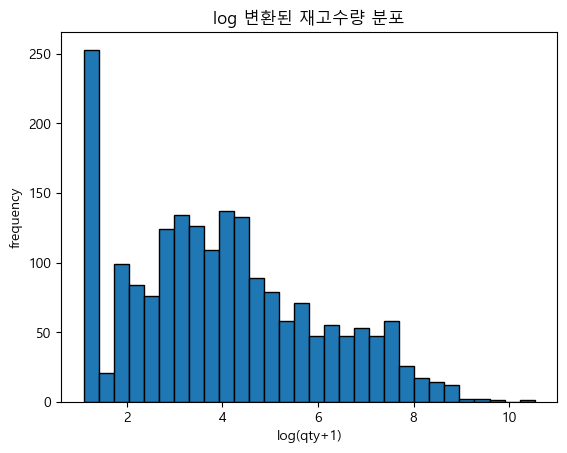

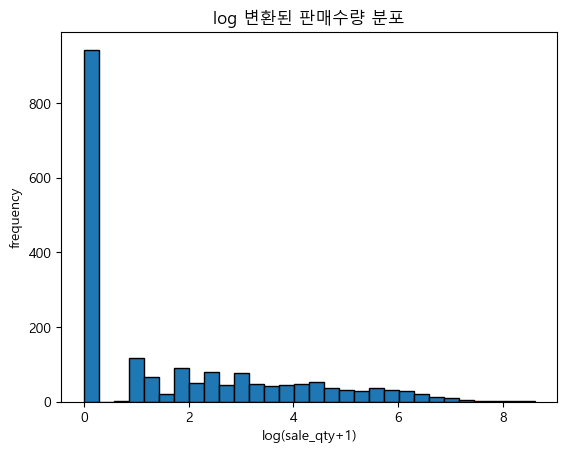

In [4]:
# 로그 변환 (log1p는 0일 때도 안전하게 변환)
df["log_qty"] = np.log1p(df["qty"])
df["log_sale_qty"] = np.log1p(df["sale_qty"])

# 히스토그램 재확인
plt.figure()
df["log_qty"].plot(kind="hist", bins=30, edgecolor="black")
plt.title("log 변환된 재고수량 분포")
plt.xlabel("log(qty+1)")
plt.ylabel("frequency")
plt.show()

plt.figure()
df["log_sale_qty"].plot(kind="hist", bins=30, edgecolor="black")
plt.title("log 변환된 판매수량 분포")
plt.xlabel("log(sale_qty+1)")
plt.ylabel("frequency")
plt.show()

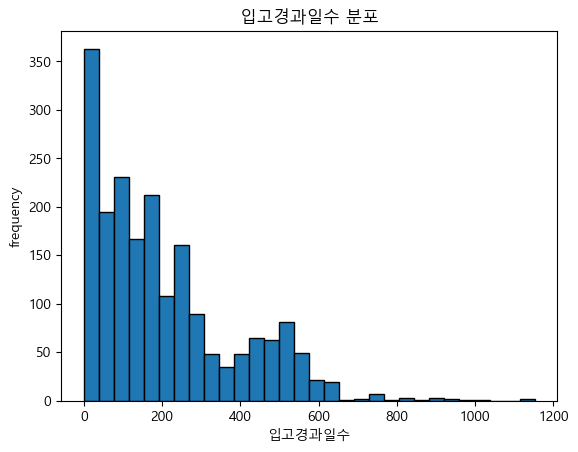

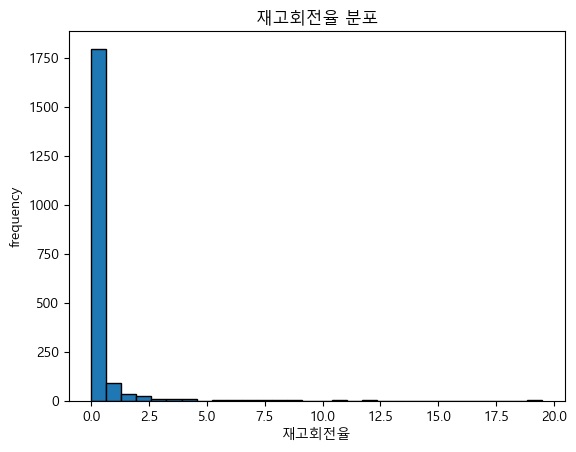

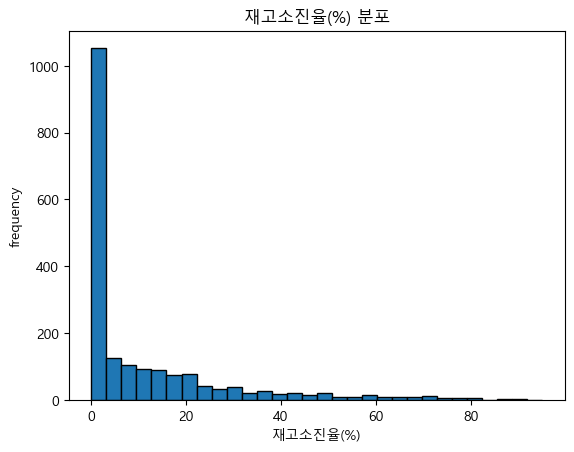

In [5]:
# 기준일 설정
REFERENCE_DATE = pd.Timestamp(2025, 6, 20)
EPS = 1e-9  # 0 나누기 방지

# 입고경과일수 계산
df["입고경과일수"] = (REFERENCE_DATE - df["ship_date"]).dt.days
df["입고경과일수"] = df["입고경과일수"].fillna(df["입고경과일수"].max())  # 결측은 최대값 대체

# 재고회전율 (판매 ÷ 재고)
df["재고회전율"] = df["sale_qty"] / (df["qty"] + EPS)

# 재고소진율 (%)
df["재고소진율(%)"] = (df["sale_qty"] / (df["sale_qty"] + df["qty"] + EPS)) * 100

# 참고용 추가지표
df["월평균판매량"] = df["sale_qty"] / 3
df["예상소진개월수"] = df["qty"] / (df["월평균판매량"] + EPS)
df["판매속도지수"] = df["월평균판매량"] / (df["qty"] + EPS)

# 입고경과일수 분포
plt.figure()
df["입고경과일수"].plot(kind="hist", bins=30, edgecolor="black")
plt.title("입고경과일수 분포")
plt.xlabel("입고경과일수")
plt.ylabel("frequency")
plt.show()

# 재고회전율 분포
plt.figure()
df["재고회전율"].plot(kind="hist", bins=30, edgecolor="black")
plt.title("재고회전율 분포")
plt.xlabel("재고회전율")
plt.ylabel("frequency")
plt.show()

# 재고소진율 분포
plt.figure()
df["재고소진율(%)"].plot(kind="hist", bins=30, edgecolor="black")
plt.title("재고소진율(%) 분포")
plt.xlabel("재고소진율(%)")
plt.ylabel("frequency")
plt.show()

In [6]:
# 스코어링용 정규화
EPS = 1e-9

turnover_max = max(df["재고회전율"].max(), EPS)
days_max = max(df["입고경과일수"].max(), 1)

# 값이 클수록 '부진'하도록 방향 통일
df["회전율_norm"] = 1 - (df["재고회전율"] / turnover_max)
df["경과일_norm"] = df["입고경과일수"] / days_max
df["소진율_norm"] = 1 - (df["재고소진율(%)"] / 100)

# 결과 일부 확인
print(df[["재고회전율", "회전율_norm", "입고경과일수", "경과일_norm", "재고소진율(%)", "소진율_norm"]].head())

      재고회전율  회전율_norm  입고경과일수  경과일_norm   재고소진율(%)  소진율_norm
0  0.000000  1.000000     501  0.434896   0.000000  1.000000
1  0.000000  1.000000     300  0.260417   0.000000  1.000000
2  0.000000  1.000000     253  0.219618   0.000000  1.000000
3  0.000000  1.000000     127  0.110243   0.000000  1.000000
4  0.164441  0.991567      73  0.063368  14.121907  0.858781


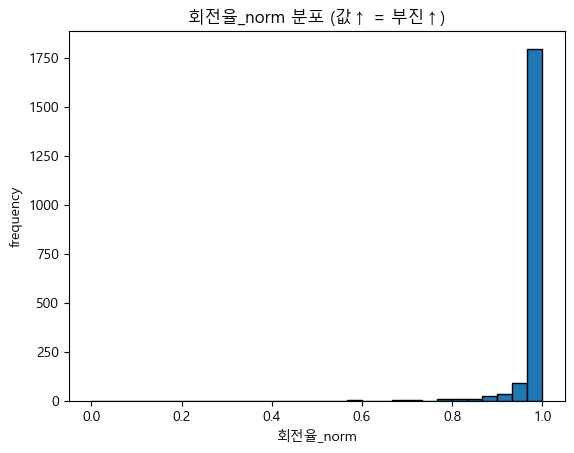

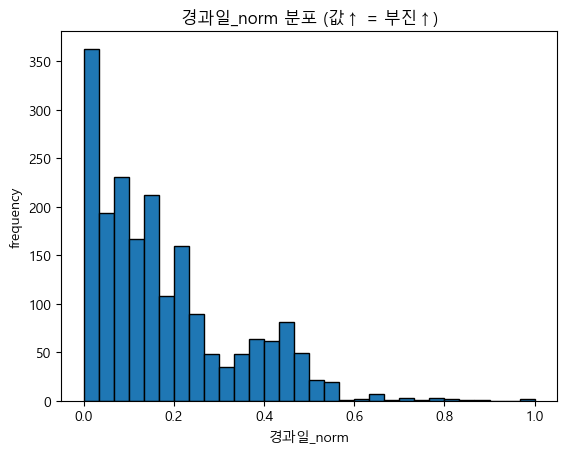

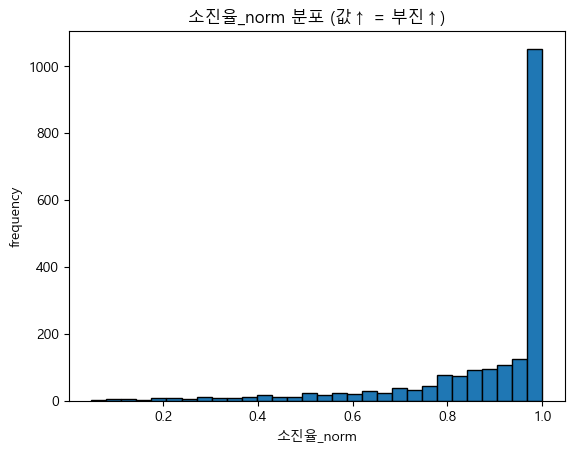

In [7]:
import matplotlib.pyplot as plt

# 회전율_norm
plt.figure()
df["회전율_norm"].plot(kind="hist", bins=30, edgecolor="black")
plt.title("회전율_norm 분포 (값↑ = 부진↑)")
plt.xlabel("회전율_norm")
plt.ylabel("frequency")
plt.show()

# 경과일_norm
plt.figure()
df["경과일_norm"].plot(kind="hist", bins=30, edgecolor="black")
plt.title("경과일_norm 분포 (값↑ = 부진↑)")
plt.xlabel("경과일_norm")
plt.ylabel("frequency")
plt.show()

# 소진율_norm
plt.figure()
df["소진율_norm"].plot(kind="hist", bins=30, edgecolor="black")
plt.title("소진율_norm 분포 (값↑ = 부진↑)")
plt.xlabel("소진율_norm")
plt.ylabel("frequency")
plt.show()

count    1975.000000
mean        0.642785
std         0.083444
min         0.149339
25%         0.595850
50%         0.637500
75%         0.686458
max         1.000000
Name: 부진재고점수, dtype: float64


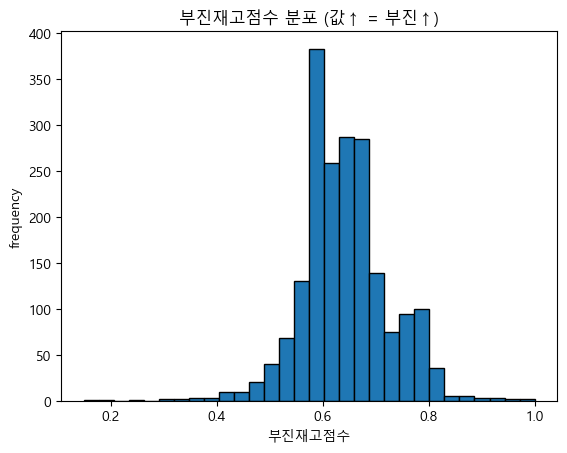

In [8]:
# 부진재고 점수 계산
W_TIME, W_SPEED, W_STOCK = 0.4, 0.4, 0.2

df["부진재고점수"] = (
    W_SPEED * df["회전율_norm"] +
    W_TIME  * df["경과일_norm"] +
    W_STOCK * df["소진율_norm"]
)

# 점수 기본 통계 확인
print(df["부진재고점수"].describe())

plt.figure()
df["부진재고점수"].plot(kind="hist", bins=30, edgecolor="black")
plt.title("부진재고점수 분포 (값↑ = 부진↑)")
plt.xlabel("부진재고점수")
plt.ylabel("frequency")
plt.show()

In [9]:
# 분위수 컷 계산
PCT_LO, PCT_HI = 0.25, 0.75
q_lo = df["부진재고점수"].quantile(PCT_LO)
q_hi = df["부진재고점수"].quantile(PCT_HI)
print(f"Q1(25%)={q_lo:.3f}, Q3(75%)={q_hi:.3f}")

# 분류 함수
def classify(score):
    if score >= q_hi:
        return "부진 재고"
    elif score >= q_lo:
        return "관심 재고"
    else:
        return "정상 재고"

# 적용
df["재고분류"] = df["부진재고점수"].apply(classify)

# 분류 결과 확인
print(df["재고분류"].value_counts())

Q1(25%)=0.596, Q3(75%)=0.686
재고분류
관심 재고    984
부진 재고    497
정상 재고    494
Name: count, dtype: int64


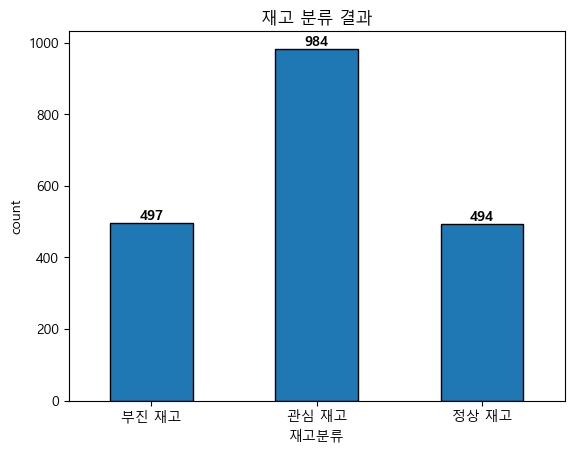

In [16]:
cnt = df["재고분류"].value_counts().reindex(["부진 재고", "관심 재고", "정상 재고"]).fillna(0)

plt.figure()
ax = cnt.plot(kind="bar", edgecolor="black")

plt.title("재고 분류 결과")
plt.xlabel("재고분류")
plt.ylabel("count")
plt.xticks(rotation=0)

# 막대 위에 수치 표시
for i, v in enumerate(cnt):
    ax.text(i, v + 0.5, int(v), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()

In [11]:
# 부진재고 여부 flag 추가
df["_is_poor"] = (df["재고분류"] == "부진 재고").astype(int)

# 그룹별 부진 비율 계산 함수
def poor_ratio(group_cols):
    g = (
        df.groupby(group_cols, dropna=False)
          .agg(총SKU=("product_code", "count"),
               부진SKU=("_is_poor", "sum"))
          .reset_index()
    )
    g["부진비율(%)"] = (g["부진SKU"] / g["총SKU"] * 100).round(2)
    return g.sort_values("부진비율(%)", ascending=False)

# 분석 대상 그룹
poor_by_biz = poor_ratio(["biz"])
poor_by_gender = poor_ratio(["gender"])
poor_by_silhouette = poor_ratio(["silhouette"])
poor_by_biz_gender = poor_ratio(["biz", "gender"])
poor_by_full = poor_ratio(["biz", "gender", "silhouette"])

# 결과 미리보기
print("[사업군별 부진 비율]\n", poor_by_biz)
print("\n[성별별 부진 비율]\n", poor_by_gender)
print("\n[제품형태별 부진 비율 상위 10]\n", poor_by_silhouette.head(10))

[사업군별 부진 비율]
   biz  총SKU  부진SKU  부진비율(%)
0  AP  1121    291    25.96
1  FW   854    206    24.12

[성별별 부진 비율]
    gender  총SKU  부진SKU  부진비율(%)
0    KIDS   274     78    28.47
2  WOMENS   700    184    26.29
1    MENS  1001    235    23.48

[제품형태별 부진 비율 상위 10]
                 silhouette  총SKU  부진SKU  부진비율(%)
4   HOODED LONG SLEEVE TOP   103     62    60.19
8                    PANTS   191     74    38.74
2                 HIGH TOP    34     12    35.29
6          LONG SLEEVE TOP   168     56    33.33
0                      BRA    33     10    30.30
16                  TIGHTS    36     10    27.78
17                    VEST    11      3    27.27
5                   JACKET    50     13    26.00
15      THREE QUARTER HIGH    59     14    23.73
7                  LOW TOP   761    180    23.65


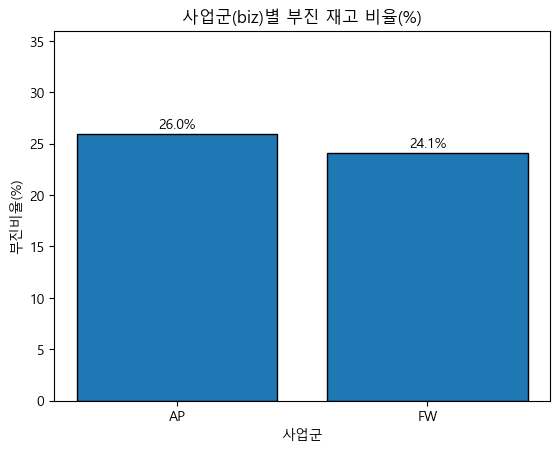

In [12]:
plt.figure()
plt.bar(poor_by_biz["biz"], poor_by_biz["부진비율(%)"], edgecolor="black")
plt.title("사업군(biz)별 부진 재고 비율(%)")
plt.xlabel("사업군")
plt.ylabel("부진비율(%)")
plt.ylim(0, poor_by_biz["부진비율(%)"].max() + 10)

# 데이터 라벨 표시
for i, v in enumerate(poor_by_biz["부진비율(%)"]):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha="center", fontsize=10)

plt.show()

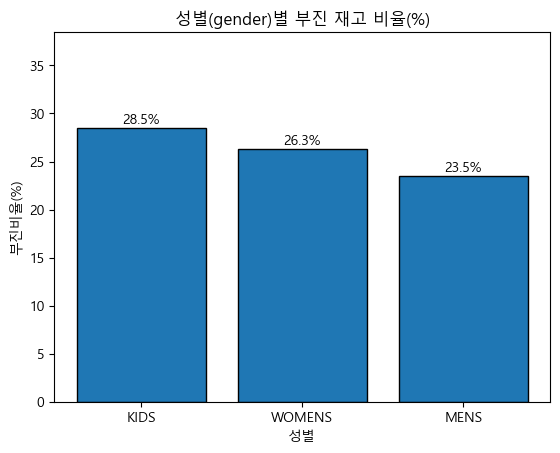

In [13]:
plt.figure()
plt.bar(poor_by_gender["gender"], poor_by_gender["부진비율(%)"], edgecolor="black")
plt.title("성별(gender)별 부진 재고 비율(%)")
plt.xlabel("성별")
plt.ylabel("부진비율(%)")
plt.ylim(0, poor_by_gender["부진비율(%)"].max() + 10)

for i, v in enumerate(poor_by_gender["부진비율(%)"]):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha="center", fontsize=10)

plt.show()

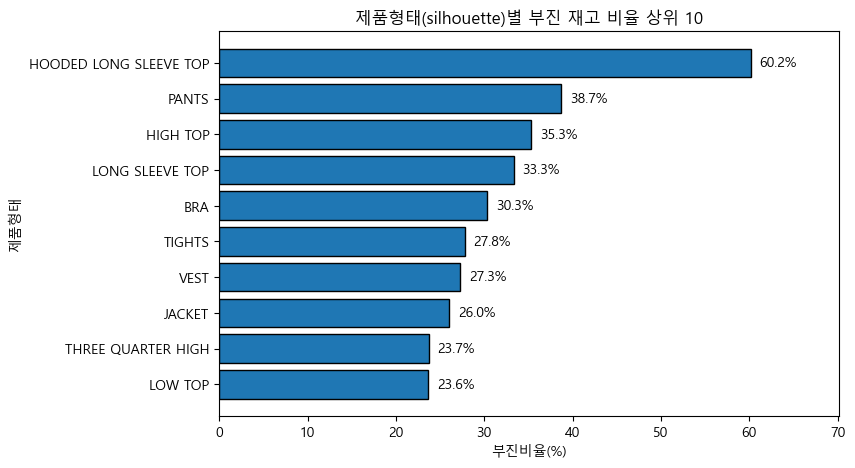

In [14]:
# 상위 10개만 시각화 (가독성)
top10 = poor_by_silhouette.head(10)

plt.figure(figsize=(8,5))
plt.barh(top10["silhouette"], top10["부진비율(%)"], edgecolor="black")
plt.title("제품형태(silhouette)별 부진 재고 비율 상위 10")
plt.xlabel("부진비율(%)")
plt.ylabel("제품형태")
plt.gca().invert_yaxis()  # 상위 항목이 위로 오도록

# 값 라벨 표시
for i, v in enumerate(top10["부진비율(%)"]):
    plt.text(v + 1, i, f"{v:.1f}%", va="center", fontsize=10)

plt.xlim(0, top10["부진비율(%)"].max() + 10)
plt.show()

In [15]:
# 파일 경로
OUTPUT_PATH = r"C:\Users\user\Desktop\daeyeon_project\result.xlsx"

# 요약 테이블 생성 함수
def poor_ratio(group_cols):
    g = (
        df.groupby(group_cols, dropna=False)
          .agg(총SKU=("product_code", "count"),
               부진SKU=("_is_poor", "sum"))
          .reset_index()
    )
    g["부진비율(%)"] = (g["부진SKU"] / g["총SKU"] * 100).round(2)
    return g.sort_values("부진비율(%)", ascending=False)

# 그룹별 요약
poor_by_biz = poor_ratio(["biz"])
poor_by_gender = poor_ratio(["gender"])
poor_by_silhouette = poor_ratio(["silhouette"])
poor_by_biz_gender = poor_ratio(["biz", "gender"])
poor_by_full = poor_ratio(["biz", "gender", "silhouette"])

# 분위수 컷 저장용
meta = pd.DataFrame({
    "항목": ["W_TIME", "W_SPEED", "W_STOCK", "PCT_LO", "PCT_HI", "Q1", "Q3"],
    "값": [0.4, 0.4, 0.2, 0.25, 0.75, q_lo, q_hi]
})

# 엑셀로 저장
with pd.ExcelWriter(OUTPUT_PATH, engine="xlsxwriter") as writer:
    # 상세 결과 (점수 내림차순 정렬)
    cols = [
        "biz", "product_code", "gender", "silhouette",
        "qty", "sale_qty", "ship_date",
        "입고경과일수", "재고회전율", "재고소진율(%)",
        "회전율_norm", "경과일_norm", "소진율_norm",
        "부진재고점수", "재고분류"
    ]
    cols = [c for c in cols if c in df.columns]
    df.sort_values("부진재고점수", ascending=False).to_excel(
        writer, sheet_name="result_detail", index=False, columns=cols
    )

    # 그룹별 요약 시트들
    poor_by_biz.to_excel(writer, sheet_name="poor_by_biz", index=False)
    poor_by_gender.to_excel(writer, sheet_name="poor_by_gender", index=False)
    poor_by_silhouette.to_excel(writer, sheet_name="poor_by_silhouette", index=False)
    poor_by_biz_gender.to_excel(writer, sheet_name="poor_by_biz_gender", index=False)
    poor_by_full.to_excel(writer, sheet_name="poor_by_full", index=False)

    # 분석 파라미터 시트
    meta.to_excel(writer, sheet_name="params", index=False)

print("✅ 완료: poor_inventory_result.xlsx 생성됨")

✅ 완료: poor_inventory_result.xlsx 생성됨
